Motivation

To use a dataset with missing information, potential outliers and colinear features in a supervised regression problem.

Study summary

The National Institutes of Health funded a study to analyze what factors may predict the survival time after diagnosis of a terminal type of liver cancer. 2,500 patients were enrolled in ten different U.S. hospital and each patient underwent a biopsy that provided a measurement of twenty quantitative cell measurements. The overall goal of this study is to identify which cell measurements may be predictors of the survival time (if any) in addition to basic patient demographic information.

Goal

    Build and evaluate a regression model that can predict the survival time using the available data. Provide:
        A description and justification of the pre-processing steps to use categorical features, solve errors in the dataset, explore feature correlations and tackle potential problem related to colinear features.
        A mathematical equation that predicts the survival time.
        A performance evaluation of the predictive model in the training dataset.


In [45]:
import numpy as np
import pandas as pd
import scipy
import shelve
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn
from sklearn.linear_model import LinearRegression
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import category_encoders as ce
import seaborn as sns
from scipy.stats import normaltest
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from scipy.optimize import minimize
from scipy.stats import shapiro
from scipy.special import expit


In [46]:
df = pd.read_excel("./CancerSurvivalData.xlsx")

In [47]:
# select categorical vars
list_categorical_cols = df.select_dtypes(include=['object']).columns.values.tolist()
print(list_categorical_cols)
df.columns

['Sex', 'Racial group']


Index(['Age (years)', 'Sex', 'Racial group', 'Cell profile 0',
       'Cell profile 1', 'Cell profile 2', 'Cell profile 3', 'Cell profile 4',
       'Cell profile 5', 'Cell profile 6', 'Cell profile 7', 'Cell profile 8',
       'Cell profile 9', 'Cell profile 10', 'Cell profile 11',
       'Cell profile 12', 'Cell profile 13', 'Cell profile 14',
       'Cell profile 15', 'Cell profile 16', 'Cell profile 17',
       'Cell profile 18', 'Cell profile 19', 'Survival time (years)'],
      dtype='object')

In [48]:
# which columns have missing values
series = df.isna().any()
columns_w_nas = series[series.values == True]
print(columns_w_nas)

Racial group      True
Cell profile 0    True
Cell profile 5    True
Cell profile 6    True
Cell profile 7    True
dtype: bool


In [49]:
# count the missing values
df.isna().sum()

Age (years)                0
Sex                        0
Racial group             237
Cell profile 0            25
Cell profile 1             0
Cell profile 2             0
Cell profile 3             0
Cell profile 4             0
Cell profile 5            25
Cell profile 6            25
Cell profile 7            25
Cell profile 8             0
Cell profile 9             0
Cell profile 10            0
Cell profile 11            0
Cell profile 12            0
Cell profile 13            0
Cell profile 14            0
Cell profile 15            0
Cell profile 16            0
Cell profile 17            0
Cell profile 18            0
Cell profile 19            0
Survival time (years)      0
dtype: int64

In [50]:
# normality test
# null hypothesis is that feature is normal


def test_normality_of_cols(df):
    normality_test_scores = {}
    for col_name in df.columns:
        x = df.loc[:, col_name]
        x_std = (x - x.mean()) / x.std()
        res = shapiro(x_std.values)
        normality_test_scores[col_name] = res 
    df_normal_test_results = pd.DataFrame(normality_test_scores)
    df_normal_test_results.index = ["skew", "pvalue"]
    df_normal_test_results = df_normal_test_results.T
    return(df_normal_test_results)
df_normal_test_results = test_normality_of_cols(df.select_dtypes(include=[np.number]))

df_normal_test_results

,skew,pvalue
Age (years),0.956336,9.601983e-27
Cell profile 0,NaN,1.000000e+00
Cell profile 1,0.929665,9.155211e-33
Cell profile 2,0.915941,3.508366e-35
Cell profile 3,0.918976,1.124647e-34
Cell profile 4,0.922211,4.047334e-34
Cell profile 5,NaN,1.000000e+00
Cell profile 6,NaN,1.000000e+00
Cell profile 7,NaN,1.000000e+00
Cell profile 8,0.920015,1.689694e-34


## Visualize distribution of categoricals before encoding

0    White
Name: Racial group, dtype: object

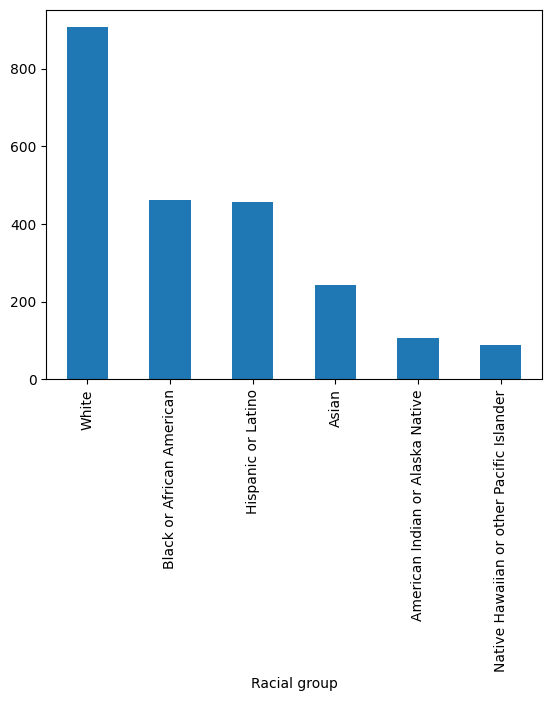

In [51]:
df["Racial group"].value_counts().plot(kind = 'bar')
df["Racial group"].mode()

0    Female
Name: Sex, dtype: object

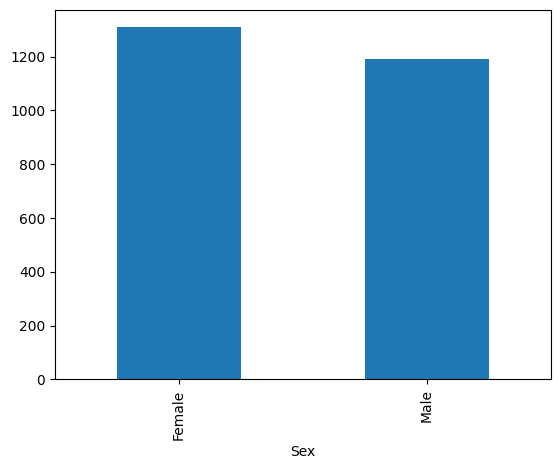

In [52]:
df["Sex"].value_counts().plot(kind = 'bar')
df["Sex"].mode()

## Visualize the relationship between missing values

/tmp/ipykernel_46572/3321107771.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


()

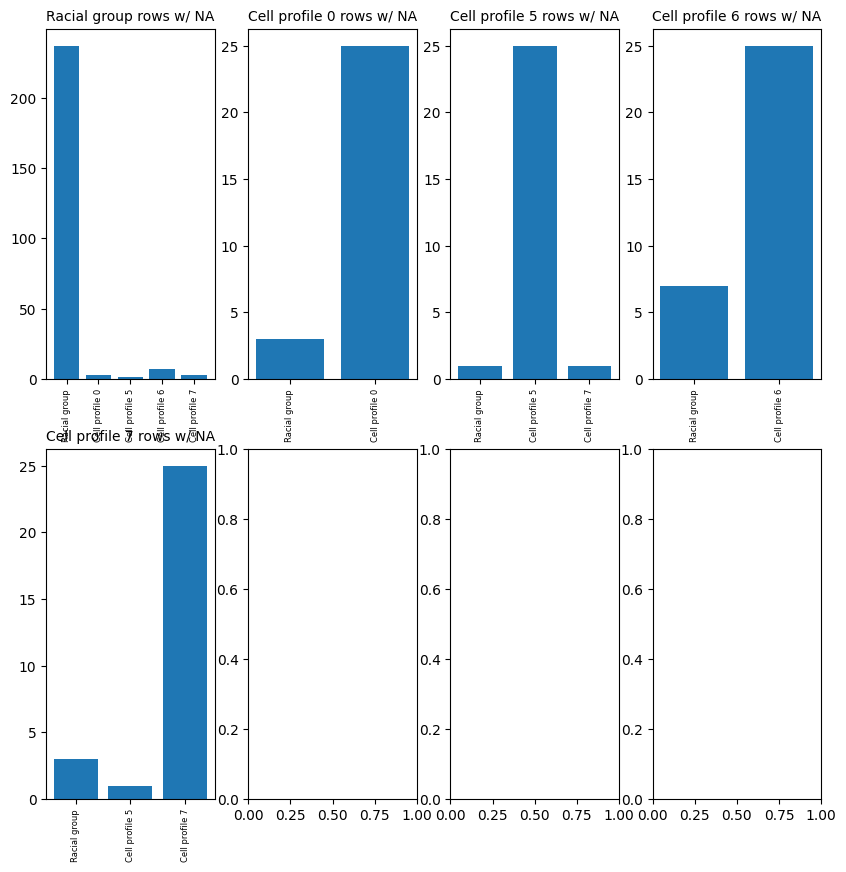

In [53]:
def plot_missing_overlap(df):
    tmp_series = df.isna().any()
    columns_w_nas = tmp_series[tmp_series.values == True]
    # init plot
    # always use 4 columns, so rownum equal the quotient of the NA columns
    # there's definitely better approaches
    n_ax_cols = 4
    n_ax_rows = (len(columns_w_nas.index) // n_ax_cols) + 1
    fig, ax = plt.subplots(nrows=n_ax_rows, ncols=n_ax_cols, figsize = (10,10))
    i_row, j_col = (0,0)
    for na_col in columns_w_nas.index:
        # only plot the columns with > 0 nas
        ser = df.loc[df[na_col].isna()].isna().sum()
        ser = ser[ser.values > 0]
        ax[i_row, j_col].set_title(f'{na_col} rows w/ NA')
        ax[i_row, j_col].title.set_size(10)
        ax[i_row, j_col].bar(ser.index, ser.values)
        ax[i_row, j_col].tick_params(axis='x', labelrotation=90)
        ax[i_row, j_col].tick_params(axis='x', which = 'major',  labelsize = 6)
        if j_col >= 3:
            j_col = 0
            i_row+= 1
        else: 
            j_col += 1
    fig.show()
    return()
plot_missing_overlap(df)

    #ser_rows_w_missing_cp7 = df.loc[df["Cell profile 7"].isna()].isna().sum()

In [54]:
def onehot_encode_categorical(df, column_name, dropna = False):
    # encode sex
    if dropna:
        df = df.dropna()
    ohe = OneHotEncoder(handle_unknown='ignore')
    ohe = ohe.fit(df[[column_name]])
    encoder_df = pd.DataFrame(ohe.transform(df[[column_name]]).toarray())
    encoder_df.columns = [f'{column_name}_{col}' for col in encoder_df.columns]
    df = df.join(encoder_df)
    df = df.drop(columns=[column_name])
    return(df, ohe)
df_encoded, ohe = onehot_encode_categorical(df, "Racial group")
print("Racial group map:", [ f'{i}_{cat}' for i,cat in enumerate(ohe.categories_[0])])
df_encoded, ohe = onehot_encode_categorical(df_encoded, "Sex")
print("Sex map:", [ f'{i}_{cat}' for i,cat in enumerate(ohe.categories_[0])])
df_encoded

Racial group map: ['0_American Indian or Alaska Native', '1_Asian', '2_Black or African American', '3_Hispanic or Latino', '4_Native Hawaiian or other Pacific Islander', '5_White', '6_nan']
Sex map: ['0_Female', '1_Male']


,Age (years),Cell profile 0,Cell profile 1,Cell profile 2,Cell profile 3,Cell profile 4,Cell profile 5,Cell profile 6,Cell profile 7,Cell profile 8,...,Survival time (years),Racial group_0,Racial group_1,Racial group_2,Racial group_3,Racial group_4,Racial group_5,Racial group_6,Sex_0,Sex_1
0,68.475758,-8.157101,-239.746069,-32.836253,-230.976922,-33.728470,-64.258003,22.956746,263.818563,22.353700,...,11.508051,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,73.986450,93.478737,-157.961018,14.631538,614.675436,-13.678756,-231.896554,29.752563,159.291946,-57.804549,...,9.522676,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,70.285954,91.730740,-203.839995,-92.186941,-186.551883,-29.879525,-40.025009,26.173054,83.489261,12.962200,...,8.472567,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,46.744625,70.212764,-17.021044,-35.898403,83.209881,-107.864887,-116.057017,32.521885,-88.881909,-50.015601,...,5.196368,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,71.733703,134.176720,9.179638,0.095330,57.317705,15.817103,-58.385986,24.084089,40.492528,-93.317918,...,11.254032,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,63.689992,250.058423,-56.084384,-14.716141,-29.002666,10.640480,-221.749835,13.893947,102.345418,69.412880,...,13.273295,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2496,78.736827,-194.146015,-92.721610,-11.284786,-91.990486,32.927714,200.511723,10.503398,350.547202,-11.878036,...,15.344215,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2497,37.484450,-231.913901,161.369095,-10.737774,183.862521,-10.625946,-87.664727,4.800412,0.440589,-71.661808,...,5.540625,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2498,50.191400,-93.543860,382.134743,-43.405837,-59.782287,9.528378,-274.671705,8.357999,-133.059524,-25.247928,...,10.616268,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


<Axes: >

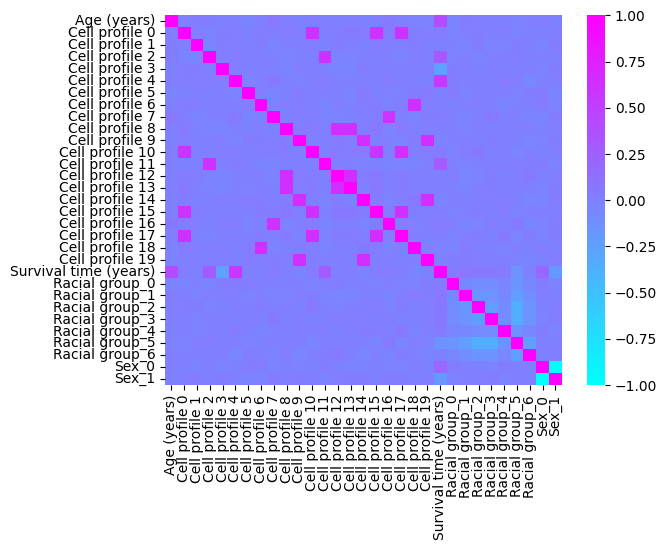

In [55]:
corr = df_encoded.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap = 'cool')

array([[<Axes: title={'center': 'Age (years)'}>,
        <Axes: title={'center': 'Cell profile 0'}>,
        <Axes: title={'center': 'Cell profile 1'}>,
        <Axes: title={'center': 'Cell profile 2'}>,
        <Axes: title={'center': 'Cell profile 3'}>,
        <Axes: title={'center': 'Cell profile 4'}>],
       [<Axes: title={'center': 'Cell profile 5'}>,
        <Axes: title={'center': 'Cell profile 6'}>,
        <Axes: title={'center': 'Cell profile 7'}>,
        <Axes: title={'center': 'Cell profile 8'}>,
        <Axes: title={'center': 'Cell profile 9'}>,
        <Axes: title={'center': 'Cell profile 10'}>],
       [<Axes: title={'center': 'Cell profile 11'}>,
        <Axes: title={'center': 'Cell profile 12'}>,
        <Axes: title={'center': 'Cell profile 13'}>,
        <Axes: title={'center': 'Cell profile 14'}>,
        <Axes: title={'center': 'Cell profile 15'}>,
        <Axes: title={'center': 'Cell profile 16'}>],
       [<Axes: title={'center': 'Cell profile 17'}>,
    

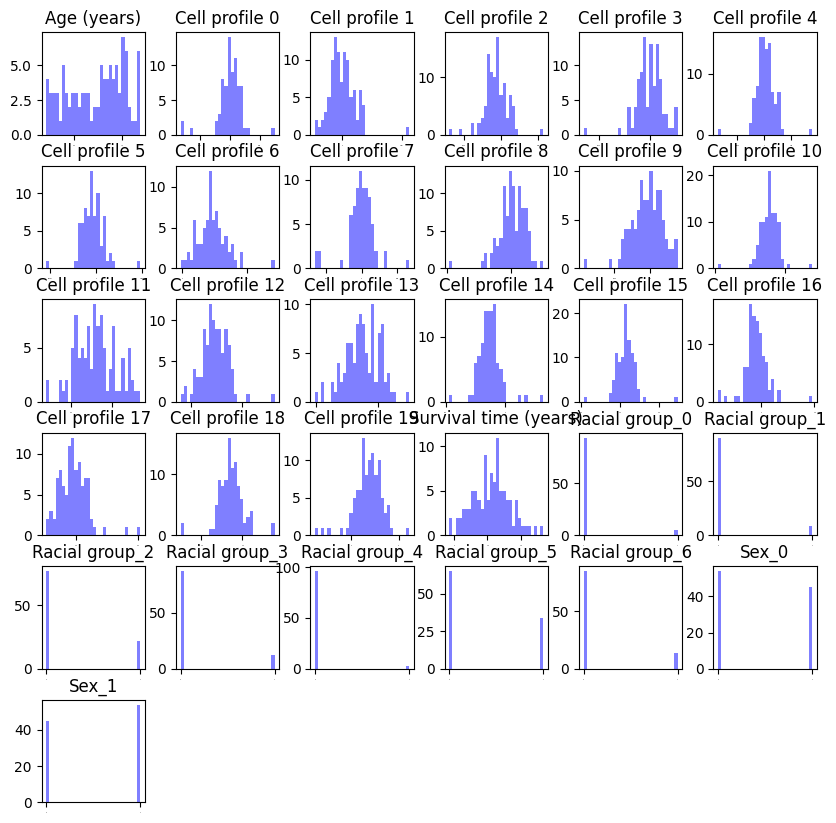

In [56]:
null_data = df_encoded[df_encoded.isnull().any(axis=1)]
null_data.hist(color = 'b', alpha = 0.5, xlabelsize=0.1, figsize = (10,10), bins = 30, grid = False )

## Visualize feature distributions

array([[<Axes: title={'center': 'Age (years)'}>,
        <Axes: title={'center': 'Cell profile 0'}>,
        <Axes: title={'center': 'Cell profile 1'}>,
        <Axes: title={'center': 'Cell profile 2'}>,
        <Axes: title={'center': 'Cell profile 3'}>,
        <Axes: title={'center': 'Cell profile 4'}>],
       [<Axes: title={'center': 'Cell profile 5'}>,
        <Axes: title={'center': 'Cell profile 6'}>,
        <Axes: title={'center': 'Cell profile 7'}>,
        <Axes: title={'center': 'Cell profile 8'}>,
        <Axes: title={'center': 'Cell profile 9'}>,
        <Axes: title={'center': 'Cell profile 10'}>],
       [<Axes: title={'center': 'Cell profile 11'}>,
        <Axes: title={'center': 'Cell profile 12'}>,
        <Axes: title={'center': 'Cell profile 13'}>,
        <Axes: title={'center': 'Cell profile 14'}>,
        <Axes: title={'center': 'Cell profile 15'}>,
        <Axes: title={'center': 'Cell profile 16'}>],
       [<Axes: title={'center': 'Cell profile 17'}>,
    

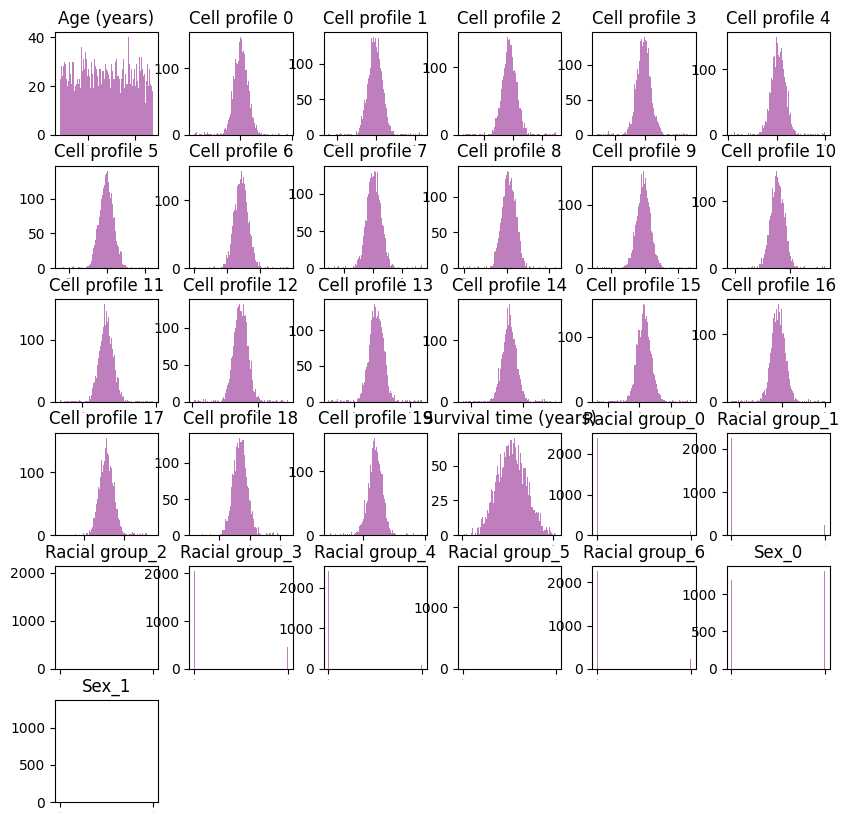

In [57]:
df_encoded.hist(color = 'purple', alpha = 0.5, xlabelsize=0.1, figsize = (10,10), bins = 100, grid = False )

## Visualize distribution of categoricals

In [58]:
df_categoricals = df_encoded[df_encoded.columns[22:].values.tolist()]
df_categoricals

,Racial group_0,Racial group_1,Racial group_2,Racial group_3,Racial group_4,Racial group_5,Racial group_6,Sex_0,Sex_1
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
2495,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2496,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2497,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2498,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [59]:
# select numericals
df_numericals = df.select_dtypes(include=[np.number]) 
# make copy
df_std = df
# standardize
df_std[df_numericals.columns] = (df_numericals - df_numericals.mean()) / df_numericals.std()
df_std

,Age (years),Sex,Racial group,Cell profile 0,Cell profile 1,Cell profile 2,Cell profile 3,Cell profile 4,Cell profile 5,Cell profile 6,...,Cell profile 11,Cell profile 12,Cell profile 13,Cell profile 14,Cell profile 15,Cell profile 16,Cell profile 17,Cell profile 18,Cell profile 19,Survival time (years)
0,0.606485,Female,Hispanic or Latino,-0.157169,-1.017084,-0.027959,-1.525573,-1.200434,-0.176158,0.109135,...,-0.010344,-0.050090,3.519516,-1.438076,-0.213394,1.644463,-0.244937,0.089880,-1.400001,0.190988
1,0.990536,Female,White,0.463286,-0.638725,0.612273,4.485953,-0.619857,-0.921435,0.635599,...,0.635521,-0.854376,-0.843348,0.665311,0.419184,0.950492,0.402342,0.619760,0.696441,-0.428246
2,0.732641,Male,White,0.452615,-0.850973,-0.828464,-1.209766,-1.088980,-0.068425,0.358299,...,-0.817892,-0.144322,-0.135236,0.486996,0.408304,0.447224,0.391210,0.340661,0.518714,-0.755772
3,-0.907998,Female,White,0.321254,0.013300,-0.069260,0.707901,-3.347191,-0.406443,0.850135,...,-0.052008,-0.776224,-0.765409,-0.687899,0.274377,-0.697179,0.254170,0.835689,-0.652301,-1.777610
4,0.833538,Male,White,0.711734,0.134512,0.416212,0.523840,0.234250,-0.150053,0.196469,...,0.437736,-1.210709,-1.198705,-0.807912,4.225621,0.161761,0.661531,0.177781,-0.771917,0.111760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.272956,Female,Hispanic or Latino,1.419156,-0.167417,0.216440,-0.089789,0.084352,-0.876325,-0.592950,...,0.236206,0.422090,0.429626,-0.321723,1.393731,0.572414,1.399536,-0.616759,-0.287334,0.741563
2496,1.321598,Female,White,-1.292573,-0.336910,0.262721,-0.537554,0.729720,1.000938,-0.855612,...,0.282894,-0.393562,-0.383794,1.417377,-5.543353,2.220269,-1.429426,-0.881125,1.446024,1.387478
2497,-1.553357,Female,Native Hawaiian or other Pacific Islander,-1.523134,0.838580,0.270099,1.423415,-0.531457,-0.280218,-1.297416,...,0.290337,-0.993417,-0.982008,-0.222678,-1.606049,-0.104151,4.685273,-1.325796,-0.188616,-1.670237
2498,-0.667786,Female,White,-0.678429,1.859900,-0.170519,-0.308594,0.052149,-1.111602,-1.021814,...,-0.154158,-0.527712,-0.517577,1.263306,-0.744839,-0.990482,-0.788731,-1.048405,1.292461,-0.087157


In [60]:
# summarize data
df.describe()

,Age (years),Cell profile 0,Cell profile 1,Cell profile 2,Cell profile 3,Cell profile 4,Cell profile 5,Cell profile 6,Cell profile 7,Cell profile 8,...,Cell profile 11,Cell profile 12,Cell profile 13,Cell profile 14,Cell profile 15,Cell profile 16,Cell profile 17,Cell profile 18,Cell profile 19,Survival time (years)
count,2.500000e+03,2.475000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.475000e+03,2.475000e+03,2.475000e+03,2.500000e+03,...,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2.500000e+03,2500.000000
mean,-5.115908e-16,1.722528e-17,1.421085e-18,-4.760636e-17,7.815970e-18,-5.684342e-18,2.870880e-17,-9.330359e-17,7.177199e-18,-4.192202e-17,...,8.284928e-16,8.526513e-17,6.821210e-17,-2.557954e-17,6.252776e-16,-2.842171e-17,1.421085e-18,3.552714e-16,-1.207923e-17,0.000000
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
min,-1.726381e+00,-5.468058e+00,-5.626138e+00,-5.457967e+00,-5.523043e+00,-5.589654e+00,-5.495674e+00,-5.614374e+00,-5.250746e+00,-5.430333e+00,...,-5.428113e+00,-5.495058e+00,-5.561016e+00,-5.634064e+00,-5.590662e+00,-5.592273e+00,-5.680287e+00,-5.494504e+00,-5.603639e+00,-3.375885
25%,-8.460688e-01,-5.307032e-01,-5.793933e-01,-5.382399e-01,-5.335336e-01,-5.623200e-01,-5.575458e-01,-5.672035e-01,-5.614847e-01,-5.377467e-01,...,-5.287379e-01,-5.497398e-01,-5.421920e-01,-5.422648e-01,-5.747286e-01,-5.471109e-01,-6.091975e-01,-5.900457e-01,-5.225314e-01,-0.702838
50%,-1.016629e-02,2.239135e-02,-2.029460e-02,-2.042004e-02,1.446182e-02,-2.241488e-02,3.838983e-04,-8.417040e-03,-7.658673e-03,4.220282e-03,...,-9.791358e-03,2.481645e-03,5.624481e-03,-1.342290e-02,-1.581334e-02,4.984053e-03,-3.466366e-02,-2.363547e-02,1.792736e-02,-0.008996
75%,8.605457e-01,5.823834e-01,5.467054e-01,5.325636e-01,5.482327e-01,5.539258e-01,5.593326e-01,5.569738e-01,5.467274e-01,5.684882e-01,...,5.504072e-01,5.667066e-01,5.711929e-01,5.526975e-01,5.486038e-01,5.612825e-01,5.477407e-01,5.441796e-01,5.784780e-01,0.672481
max,1.755343e+00,5.500357e+00,5.603200e+00,5.427858e+00,5.558470e+00,5.538089e+00,5.495643e+00,5.502136e+00,5.528755e+00,5.576394e+00,...,5.483692e+00,5.514812e+00,5.311584e+00,5.673843e+00,5.494532e+00,5.597009e+00,5.621720e+00,5.595152e+00,5.630696e+00,3.064667


In [61]:
# split predictors and outcomes
y = df.loc[: , "Survival time (years)"]
x = df.iloc[:, 0:-1]
x_numericals = x.select_dtypes(include=[np.number]) 
print(x_numericals.columns)

Index(['Age (years)', 'Cell profile 0', 'Cell profile 1', 'Cell profile 2',
       'Cell profile 3', 'Cell profile 4', 'Cell profile 5', 'Cell profile 6',
       'Cell profile 7', 'Cell profile 8', 'Cell profile 9', 'Cell profile 10',
       'Cell profile 11', 'Cell profile 12', 'Cell profile 13',
       'Cell profile 14', 'Cell profile 15', 'Cell profile 16',
       'Cell profile 17', 'Cell profile 18', 'Cell profile 19'],
      dtype='object')


In [62]:
#df_encoded_dropped.hist(color = 'r', alpha = 0.5, xlabelsize=0.1, figsize = (10,10), bins = 100 )

Visualize distribution of categoricals

# Begin actual transformation for final data

In [63]:
df = pd.read_excel("./CancerSurvivalData.xlsx")

## Impute missing values

- Use median for numerical values
- Use mode for categorical values

Will start with original dataframe because encoding got rid of NA values

In [64]:

print(type(df["Cell profile 0"][df["Cell profile 0"].index == 2459].values[0]))
print(np.nan)

<class 'numpy.float64'>
nan


In [65]:
### test code for getting the right shape/obj for SimpleImputer
#print(df["Cell profile 0"].isna().sum())
#arr = df["Cell profile 0"].to_numpy().reshape(-1, 1)
#imp_numerical = SimpleImputer(missing_values=np.nan, strategy='median')
## encoders expect a list of arrays for some reason
#imp_numerical.fit(arr)
#arr = imp_numerical.transform(arr)
#print(np.isnan(arr).sum())
#df_test  = pd.DataFrame(arr)
#df_test["test_col"] = pd.DataFrame(arr)
#df_test
df.isna().sum()

Age (years)                0
Sex                        0
Racial group             237
Cell profile 0            25
Cell profile 1             0
Cell profile 2             0
Cell profile 3             0
Cell profile 4             0
Cell profile 5            25
Cell profile 6            25
Cell profile 7            25
Cell profile 8             0
Cell profile 9             0
Cell profile 10            0
Cell profile 11            0
Cell profile 12            0
Cell profile 13            0
Cell profile 14            0
Cell profile 15            0
Cell profile 16            0
Cell profile 17            0
Cell profile 18            0
Cell profile 19            0
Survival time (years)      0
dtype: int64

In [66]:
print("before", df.isna().values.sum())
def median_impute(df, cols_to_impute):

    for col in cols_to_impute:
        # encoders expect column vector
        arr = df[col].to_numpy().reshape(-1, 1)
        imp_numerical = SimpleImputer(missing_values=np.nan, strategy='median')
        imp_numerical.fit(arr)
        arr = imp_numerical.transform(arr)
        df[col] = pd.DataFrame(arr)
    return(df)

df_numerical_predictors = df.select_dtypes(include=[np.number]) 
df_numerical_predictors.drop(columns=["Survival time (years)"], inplace=True)
cols_to_impute  = df_numerical_predictors.columns
df_numeric_imputed = median_impute(df, cols_to_impute)
df_numeric_imputed.isna().values.sum()



before 337


237

In [67]:
def mode_impute(df, cols_to_impute):
    for col in cols_to_impute:
        # encoders expect column vector
        arr = df[col].to_numpy().reshape(-1, 1)
        imp_categorical = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        imp_categorical.fit(arr)
        arr = imp_categorical.transform(arr)
        df[col] = pd.DataFrame(arr)
    return(df)

cols_to_impute = ["Racial group"]
df_imputed = mode_impute(df_numeric_imputed, cols_to_impute)
print("na after:", df_imputed.isna().values.sum())

na after: 0


## Encode

In [68]:
def onehot_encode_categorical(df, column_name, dropna = False):
    # encode sex
    if dropna:
        df = df.dropna()
    ohe = OneHotEncoder(handle_unknown='ignore')
    ohe = ohe.fit(df[[column_name]])
    encoder_df = pd.DataFrame(ohe.transform(df[[column_name]]).toarray())
    encoder_df.columns = [f'{column_name}_{col}' for col in encoder_df.columns]
    df = df.join(encoder_df)
    df = df.drop(columns=[column_name])
    return(df, ohe)
df_imputed_encoded, ohe = onehot_encode_categorical(df_imputed, "Racial group")
print("Racial group map:", [ f'{i}_{cat}' for i,cat in enumerate(ohe.categories_[0])])
df_imputed_encoded, ohe = onehot_encode_categorical(df_imputed_encoded, "Sex")
print("Sex map:", [ f'{i}_{cat}' for i,cat in enumerate(ohe.categories_[0])])
df_imputed_encoded

Racial group map: ['0_American Indian or Alaska Native', '1_Asian', '2_Black or African American', '3_Hispanic or Latino', '4_Native Hawaiian or other Pacific Islander', '5_White']
Sex map: ['0_Female', '1_Male']


,Age (years),Cell profile 0,Cell profile 1,Cell profile 2,Cell profile 3,Cell profile 4,Cell profile 5,Cell profile 6,Cell profile 7,Cell profile 8,...,Cell profile 19,Survival time (years),Racial group_0,Racial group_1,Racial group_2,Racial group_3,Racial group_4,Racial group_5,Sex_0,Sex_1
0,68.475758,-8.157101,-239.746069,-32.836253,-230.976922,-33.728470,-64.258003,22.956746,263.818563,22.353700,...,0.024656,11.508051,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,73.986450,93.478737,-157.961018,14.631538,614.675436,-13.678756,-231.896554,29.752563,159.291946,-57.804549,...,2.884620,9.522676,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,70.285954,91.730740,-203.839995,-92.186941,-186.551883,-29.879525,-40.025009,26.173054,83.489261,12.962200,...,2.642166,8.472567,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,46.744625,70.212764,-17.021044,-35.898403,83.209881,-107.864887,-116.057017,32.521885,-88.881909,-50.015601,...,1.044667,5.196368,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,71.733703,134.176720,9.179638,0.095330,57.317705,15.817103,-58.385986,24.084089,40.492528,-93.317918,...,0.881487,11.254032,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,63.689992,250.058423,-56.084384,-14.716141,-29.002666,10.640480,-221.749835,13.893947,102.345418,69.412880,...,1.542555,13.273295,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2496,78.736827,-194.146015,-92.721610,-11.284786,-91.990486,32.927714,200.511723,10.503398,350.547202,-11.878036,...,3.907200,15.344215,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2497,37.484450,-231.913901,161.369095,-10.737774,183.862521,-10.625946,-87.664727,4.800412,0.440589,-71.661808,...,1.677226,5.540625,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2498,50.191400,-93.543860,382.134743,-43.405837,-59.782287,9.528378,-274.671705,8.357999,-133.059524,-25.247928,...,3.697711,10.616268,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


## Standardize

In [69]:
# select numericals
df_numericals = df_imputed_encoded.select_dtypes(include=[np.number]).drop(columns=["Survival time (years)"])
# make copy
df_imputed_encoded_std = df_imputed_encoded
# standardize
df_imputed_encoded_std[df_numericals.columns] = (df_numericals - df_numericals.mean()) / df_numericals.std()
df_imputed_encoded_std

,Age (years),Cell profile 0,Cell profile 1,Cell profile 2,Cell profile 3,Cell profile 4,Cell profile 5,Cell profile 6,Cell profile 7,Cell profile 8,...,Cell profile 19,Survival time (years),Racial group_0,Racial group_1,Racial group_2,Racial group_3,Racial group_4,Racial group_5,Sex_0,Sex_1
0,0.606485,-0.158186,-1.017084,-0.027959,-1.525573,-1.200434,-0.177050,0.109769,1.641075,-0.037829,...,-1.400001,11.508051,-0.21038,-0.328058,-0.476659,2.116758,-0.192092,-0.917585,0.954437,-0.954437
1,0.990536,0.465395,-0.638725,0.612273,4.485953,-0.619857,-0.926083,0.638887,0.942719,-0.833909,...,0.696441,9.522676,-0.21038,-0.328058,-0.476659,-0.472232,-0.192092,1.089381,0.954437,-0.954437
2,0.732641,0.454670,-0.850973,-0.828464,-1.209766,-1.088980,-0.068773,0.360189,0.436272,-0.131099,...,0.518714,8.472567,-0.21038,-0.328058,-0.476659,-0.472232,-0.192092,1.089381,-1.047319,1.047319
3,-0.907998,0.322648,0.013300,-0.069260,0.707901,-3.347191,-0.408495,0.854504,-0.715362,-0.756555,...,-0.652301,5.196368,-0.21038,-0.328058,-0.476659,-0.472232,-0.192092,1.089381,0.954437,-0.954437
4,0.833538,0.715095,0.134512,0.416212,0.523840,0.234250,-0.150813,0.197543,0.149005,-1.186606,...,-0.771917,11.254032,-0.21038,-0.328058,-0.476659,-0.472232,-0.192092,1.089381,-1.047319,1.047319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.272956,1.426080,-0.167417,0.216440,-0.089789,0.084352,-0.880746,-0.595854,0.562252,0.429533,...,-0.287334,13.273295,-0.21038,-0.328058,-0.476659,2.116758,-0.192092,-0.917585,0.954437,-0.954437
2496,1.321598,-1.299309,-0.336910,0.262721,-0.537554,0.729720,1.005979,-0.859840,2.220520,-0.377796,...,1.446024,15.344215,-0.21038,-0.328058,-0.476659,-0.472232,-0.192092,1.089381,0.954437,-0.954437
2497,-1.553357,-1.531032,0.838580,0.270099,1.423415,-0.531457,-0.281634,-1.303870,-0.118587,-0.971531,...,-0.188616,5.540625,-0.21038,-0.328058,-0.476659,-0.472232,5.203754,-0.917585,0.954437,-0.954437
2498,-0.667786,-0.682071,1.859900,-0.170519,-0.308594,0.052149,-1.117208,-1.026879,-1.010518,-0.510578,...,1.292461,10.616268,-0.21038,-0.328058,-0.476659,-0.472232,-0.192092,1.089381,0.954437,-0.954437


<Axes: >

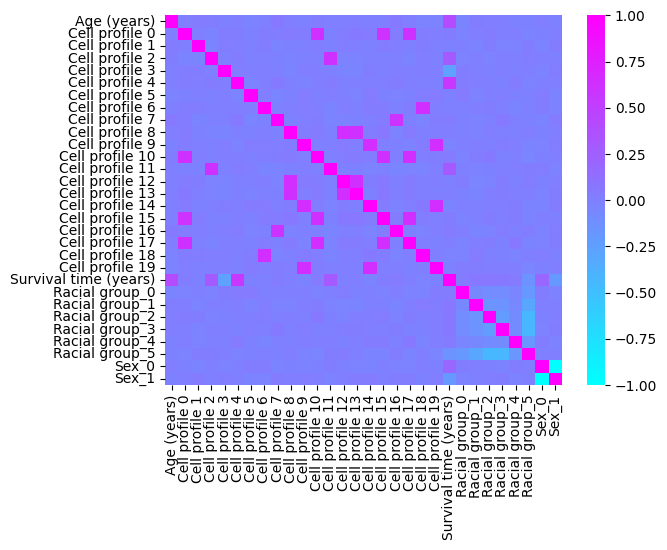

In [70]:
corr = df_imputed_encoded_std.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap = 'cool')

In [102]:
# select the final predictor variables
feature_cols = df_imputed_encoded_std.columns.to_list()
feature_cols.remove('Survival time (years)')
X = df_imputed_encoded_std.loc[:, feature_cols]
y = df_imputed_encoded_std.loc[:, "Survival time (years)"]
X

,Age (years),Cell profile 0,Cell profile 1,Cell profile 2,Cell profile 3,Cell profile 4,Cell profile 5,Cell profile 6,Cell profile 7,Cell profile 8,...,Cell profile 18,Cell profile 19,Racial group_0,Racial group_1,Racial group_2,Racial group_3,Racial group_4,Racial group_5,Sex_0,Sex_1
0,0.606485,-0.158186,-1.017084,-0.027959,-1.525573,-1.200434,-0.177050,0.109769,1.641075,-0.037829,...,0.089880,-1.400001,-0.21038,-0.328058,-0.476659,2.116758,-0.192092,-0.917585,0.954437,-0.954437
1,0.990536,0.465395,-0.638725,0.612273,4.485953,-0.619857,-0.926083,0.638887,0.942719,-0.833909,...,0.619760,0.696441,-0.21038,-0.328058,-0.476659,-0.472232,-0.192092,1.089381,0.954437,-0.954437
2,0.732641,0.454670,-0.850973,-0.828464,-1.209766,-1.088980,-0.068773,0.360189,0.436272,-0.131099,...,0.340661,0.518714,-0.21038,-0.328058,-0.476659,-0.472232,-0.192092,1.089381,-1.047319,1.047319
3,-0.907998,0.322648,0.013300,-0.069260,0.707901,-3.347191,-0.408495,0.854504,-0.715362,-0.756555,...,0.835689,-0.652301,-0.21038,-0.328058,-0.476659,-0.472232,-0.192092,1.089381,0.954437,-0.954437
4,0.833538,0.715095,0.134512,0.416212,0.523840,0.234250,-0.150813,0.197543,0.149005,-1.186606,...,0.177781,-0.771917,-0.21038,-0.328058,-0.476659,-0.472232,-0.192092,1.089381,-1.047319,1.047319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.272956,1.426080,-0.167417,0.216440,-0.089789,0.084352,-0.880746,-0.595854,0.562252,0.429533,...,-0.616759,-0.287334,-0.21038,-0.328058,-0.476659,2.116758,-0.192092,-0.917585,0.954437,-0.954437
2496,1.321598,-1.299309,-0.336910,0.262721,-0.537554,0.729720,1.005979,-0.859840,2.220520,-0.377796,...,-0.881125,1.446024,-0.21038,-0.328058,-0.476659,-0.472232,-0.192092,1.089381,0.954437,-0.954437
2497,-1.553357,-1.531032,0.838580,0.270099,1.423415,-0.531457,-0.281634,-1.303870,-0.118587,-0.971531,...,-1.325796,-0.188616,-0.21038,-0.328058,-0.476659,-0.472232,5.203754,-0.917585,0.954437,-0.954437
2498,-0.667786,-0.682071,1.859900,-0.170519,-0.308594,0.052149,-1.117208,-1.026879,-1.010518,-0.510578,...,-1.048405,1.292461,-0.21038,-0.328058,-0.476659,-0.472232,-0.192092,1.089381,0.954437,-0.954437


In [72]:
# normality test
# null hypothesis is that feature is normal

def test_normality_of_cols(df):
    normality_test_scores = {}
    for col_name in df.columns:
        x = df.loc[:, col_name]
        x_std = (x - x.mean()) / x.std()
        res = shapiro(x_std.values)
        normality_test_scores[col_name] = res 
    df_normal_test_results = pd.DataFrame(normality_test_scores)
    df_normal_test_results.index = ["skew", "pvalue"]
    df_normal_test_results = df_normal_test_results.T
    return(df_normal_test_results)
df_normal_test_results = test_normality_of_cols(X)
df_normal_test_results

,skew,pvalue
Age (years),0.956336,9.601983e-27
Cell profile 0,0.912353,9.234053e-36
Cell profile 1,0.929665,9.155211e-33
Cell profile 2,0.915941,3.508366e-35
Cell profile 3,0.918976,1.124647e-34
Cell profile 4,0.922211,4.047334e-34
Cell profile 5,0.933181,4.368016e-32
Cell profile 6,0.930348,1.234378e-32
Cell profile 7,0.924330,9.582369e-34
Cell profile 8,0.920015,1.689694e-34


In [73]:
reg = LinearRegression().fit(X,y)
reg.score(X,y)

0.7071116322276729

In [74]:
reg.coef_

array([ 1.28117381e+00,  2.04961127e-02, -2.18994654e-02,  5.29729243e-01,
       -8.40194798e-01,  1.78497068e+00,  1.19523139e-02,  5.48444684e-03,
       -8.24527957e-02,  5.59764689e-03, -6.00064463e-02,  7.03104732e-02,
        5.49104932e-01,  6.42080189e-03, -1.60980255e-02, -6.90959296e-02,
        4.25323515e-02,  8.71572854e-02, -7.34721107e-02, -2.15328349e-02,
        9.65651905e-02,  2.20664229e+11,  3.24403736e+11,  4.25405344e+11,
        4.22902058e+11,  2.02913312e+11,  5.45544234e+11,  4.16775964e+10,
        4.16775964e+10])

In [97]:
X.columns

Index(['Age (years)', 'Cell profile 0', 'Cell profile 1', 'Cell profile 2',
       'Cell profile 3', 'Cell profile 4', 'Cell profile 5', 'Cell profile 6',
       'Cell profile 7', 'Cell profile 8', 'Cell profile 9', 'Cell profile 10',
       'Cell profile 11', 'Cell profile 12', 'Cell profile 13',
       'Cell profile 14', 'Cell profile 15', 'Cell profile 16',
       'Cell profile 17', 'Cell profile 18', 'Cell profile 19',
       'Racial group_0', 'Racial group_1', 'Racial group_2', 'Racial group_3',
       'Racial group_4', 'Racial group_5', 'Sex_0', 'Sex_1'],
      dtype='object')

In [100]:
# add default bias constant
x_sm = sm.add_constant(X)

model = sm.OLS(y, x_sm)
ols_results = model.fit()
ols_results.params
df_ols_summary = ols_results.summary().tables[1]
df_ols_summary

,coef,std err,t,P>|t|,[0.025,0.975]
const,10.8957,0.035,312.268,0.000,10.827,10.964
Age (years),1.2812,0.035,36.542,0.000,1.212,1.350
Cell profile 0,0.0204,0.049,0.414,0.679,-0.076,0.117
Cell profile 1,-0.0220,0.035,-0.626,0.531,-0.091,0.047
Cell profile 2,0.5298,0.044,11.970,0.000,0.443,0.617
Cell profile 3,-0.8403,0.035,-24.019,0.000,-0.909,-0.772
Cell profile 4,1.7850,0.035,50.929,0.000,1.716,1.854
Cell profile 5,0.0120,0.035,0.342,0.732,-0.057,0.081
Cell profile 6,0.0054,0.045,0.121,0.904,-0.083,0.094
Cell profile 7,-0.0826,0.044,-1.891,0.059,-0.168,0.003


In [104]:
ols_results.predict()

array([11.78871508,  8.05838136,  8.937155  , ...,  7.32432451,
       10.18754254, 11.97677877])

In [173]:
inputData = X.to_numpy()
def f(xData, b, x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17, x18, x19, x20, x21, x22, x23, x24, x25, x26, x27, x28):
    v_b = b
    v_x0 = xData[:, 0] * x0
    v_x1 = xData[:, 1] * x1
    v_x2 = xData[:, 2] * x2
    v_x3 = xData[:, 3] * x3
    v_x4 = xData[:, 4] * x4
    v_x5 = xData[:, 5] * x5
    v_x6 = xData[:, 6] * x6
    v_x7 = xData[:, 7] * x7
    v_x8 = xData[:, 8] * x8
    v_x9 = xData[:, 9] * x9 
    v_x10 = xData[:, 10] * x10
    v_x11 = xData[:, 11] * x11
    v_x12 = xData[:, 12] * x12
    v_x13 = xData[:, 13] * x13
    v_x14 = xData[:, 14] * x14
    v_x15 = xData[:, 15] * x15
    v_x16 = xData[:, 16] * x16
    v_x17 = xData[:, 17] * x17
    v_x18 = xData[:, 18] * x18
    v_x19 = xData[:, 19] * x19
    v_x20 = xData[:, 20] * x20
    v_x21 = xData[:, 21] * x21
    v_x22 = xData[:, 22] * x22
    v_x23 = xdata[:, 23] * x23
    v_x24 = xdata[:, 24] * x24
    v_x25 = xdata[:, 25] * x25
    v_x26 = xdata[:, 26] * x26
    v_x27 = xdata[:, 27] * x27
    v_x28 = xdata[:, 28] * x28
    features = [ v_b,
    v_x0,
    v_x1,
    v_x2,
    v_x3,
    v_x4,
    v_x5,
    v_x6,
    v_x7,
    v_x8,
    v_x9,
    v_x10,
    v_x11,
    v_x12,
    v_x13,
    v_x14,
    v_x15,
    v_x16,
    v_x17,
    v_x18,
    v_x19,
    v_x20,
    v_x21,
    v_x22,
    v_x23,
    v_x24,
    v_x25,
    v_x26,
    v_x27,
    v_x28,
    ]
    value = sum(features)
    #value = sum([weight * xdata[:, i] for i,weight in enumerate(weights)] ) + b
    return value
popt, pcov = scipy.optimize.curve_fit(f, inputdata, y.ravel(), method='lm', p0=np.ones(len(x.columns) + 1))
nonlinearpredictions = f(inputdata, *popt)
rmse = round(np.sqrt(sklearn.metrics.mean_squared_error(y, nonlinearpredictions)), 3)
print(rmse)
print([ round(coef, 3) for coef in popt])

1.735
[10.896, 1.281, 0.02, -0.022, 0.53, -0.84, 1.785, 0.012, 0.005, -0.083, 0.006, -0.06, 0.07, 0.549, 0.006, -0.016, -0.069, 0.043, 0.087, -0.073, -0.022, 0.096, -128.955, -189.603, -248.659, -247.184, -118.636, -319.319, -53.071, -53.669]


In [79]:
l = [f'{X.columns[i-1]}*{round(coef,3)}' for i,coef in enumerate(popt[1:])]
l.insert(0,'bias*10.896')
print(l)

['bias*10.896', 'Sex_1*1.281', 'Age (years)*0.02', 'Cell profile 0*-0.022', 'Cell profile 1*0.53', 'Cell profile 2*-0.84', 'Cell profile 3*1.785', 'Cell profile 4*0.012', 'Cell profile 5*0.005', 'Cell profile 6*-0.083', 'Cell profile 7*0.006', 'Cell profile 8*-0.06', 'Cell profile 9*0.07', 'Cell profile 10*0.549', 'Cell profile 11*0.006', 'Cell profile 12*-0.016', 'Cell profile 13*-0.069', 'Cell profile 14*0.043', 'Cell profile 15*0.087', 'Cell profile 16*-0.073', 'Cell profile 17*-0.022', 'Cell profile 18*0.096', 'Cell profile 19*131.371', 'Racial group_0*193.108', 'Racial group_1*253.206', 'Racial group_2*251.728', 'Racial group_3*120.748', 'Racial group_4*324.279', 'Racial group_5*-18.026', 'Sex_0*-18.624']


In [80]:
df_predicted = X.copy()
df_predicted.loc[:,"Survival time (years)"] = y
df_predicted.loc[:, "Prediction"] = nonLinearPredictions
df_predicted.loc[:, "Residual"] = df_predicted.loc[:, "Survival time (years)"] - df_predicted.loc[:, "Prediction"]
df_predicted

,Age (years),Cell profile 0,Cell profile 1,Cell profile 2,Cell profile 3,Cell profile 4,Cell profile 5,Cell profile 6,Cell profile 7,Cell profile 8,...,Racial group_1,Racial group_2,Racial group_3,Racial group_4,Racial group_5,Sex_0,Sex_1,Survival time (years),Prediction,Residual
0,0.606485,-0.158186,-1.017084,-0.027959,-1.525573,-1.200434,-0.177050,0.109769,1.641075,-0.037829,...,-0.328058,-0.476659,2.116758,-0.192092,-0.917585,0.954437,-0.954437,11.508051,11.788723,-0.280672
1,0.990536,0.465395,-0.638725,0.612273,4.485953,-0.619857,-0.926083,0.638887,0.942719,-0.833909,...,-0.328058,-0.476659,-0.472232,-0.192092,1.089381,0.954437,-0.954437,9.522676,8.058374,1.464302
2,0.732641,0.454670,-0.850973,-0.828464,-1.209766,-1.088980,-0.068773,0.360189,0.436272,-0.131099,...,-0.328058,-0.476659,-0.472232,-0.192092,1.089381,-1.047319,1.047319,8.472567,8.937152,-0.464585
3,-0.907998,0.322648,0.013300,-0.069260,0.707901,-3.347191,-0.408495,0.854504,-0.715362,-0.756555,...,-0.328058,-0.476659,-0.472232,-0.192092,1.089381,0.954437,-0.954437,5.196368,3.208790,1.987579
4,0.833538,0.715095,0.134512,0.416212,0.523840,0.234250,-0.150813,0.197543,0.149005,-1.186606,...,-0.328058,-0.476659,-0.472232,-0.192092,1.089381,-1.047319,1.047319,11.254032,11.511322,-0.257291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.272956,1.426080,-0.167417,0.216440,-0.089789,0.084352,-0.880746,-0.595854,0.562252,0.429533,...,-0.328058,-0.476659,2.116758,-0.192092,-0.917585,0.954437,-0.954437,13.273295,12.806613,0.466682
2496,1.321598,-1.299309,-0.336910,0.262721,-0.537554,0.729720,1.005979,-0.859840,2.220520,-0.377796,...,-0.328058,-0.476659,-0.472232,-0.192092,1.089381,0.954437,-0.954437,15.344215,14.472388,0.871828
2497,-1.553357,-1.531032,0.838580,0.270099,1.423415,-0.531457,-0.281634,-1.303870,-0.118587,-0.971531,...,-0.328058,-0.476659,-0.472232,5.203754,-0.917585,0.954437,-0.954437,5.540625,7.324327,-1.783702
2498,-0.667786,-0.682071,1.859900,-0.170519,-0.308594,0.052149,-1.117208,-1.026879,-1.010518,-0.510578,...,-0.328058,-0.476659,-0.472232,-0.192092,1.089381,0.954437,-0.954437,10.616268,10.187538,0.428730


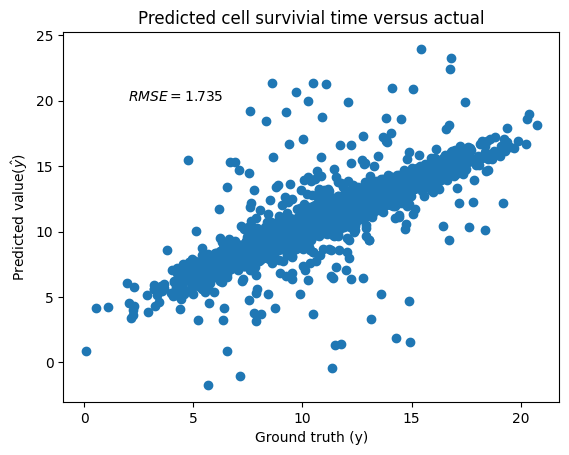

In [81]:
def nlr_performance_plot(df_predicted, col_y, col_y_pred):
    y = df_predicted.loc[:, col_y]
    y_pred = df_predicted.loc[:, col_y_pred]
    rmse = round(np.sqrt(sklearn.metrics.mean_squared_error(y, y_pred)), 3)
    fig, ax = plt.subplots()
    ax.set_xlabel("Ground truth (y)")
    ax.set_ylabel("Predicted value($\hat{y}$)")
    ax.scatter(y, y_pred)
    m, b = np.polyfit(y_pred, y, 1)
#    ax.text(x = 100, y = 160, s = f"$R^2 = ${r_squared}")
#    ax.text(x = 100, y = 150, s = f"$MAE = ${mae}")
#    ax.text(x = 100, y = 140, s = f"$MSE = ${mse}")
    ax.text(x = 2, y = 20, s = f"$RMSE = ${rmse}")
    ax.set_title("Predicted cell survivial time versus actual")

nlr_performance_plot(df_predicted, "Survival time (years)", "Prediction")

/home/jake/ghub/bios_7747/.venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


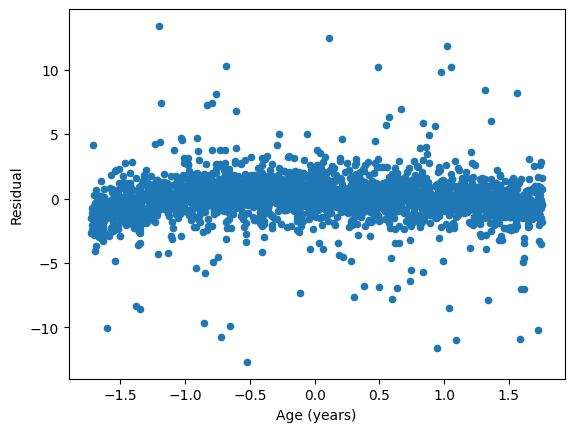

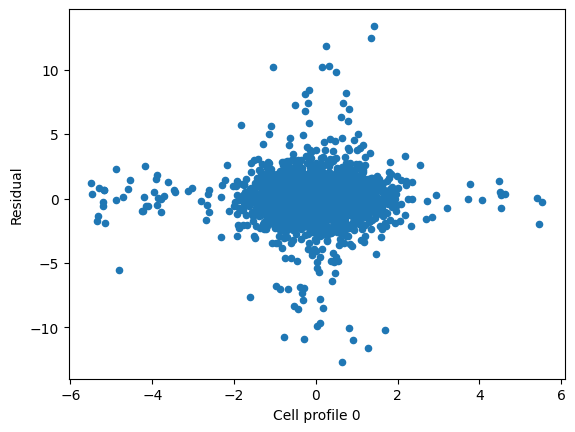

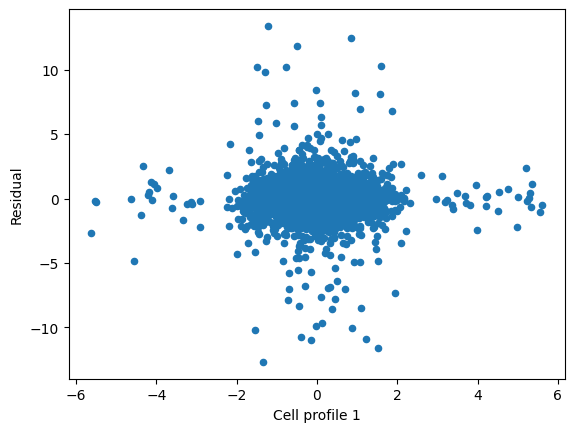

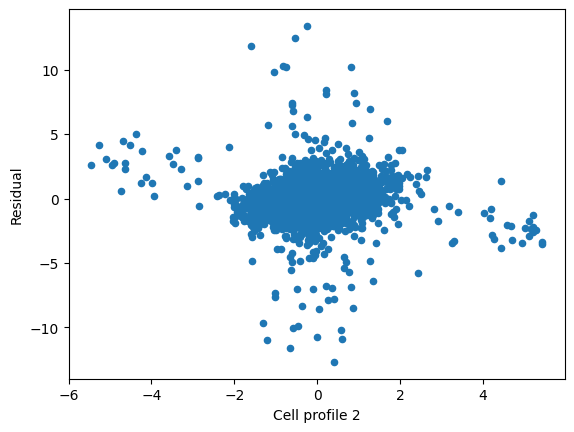

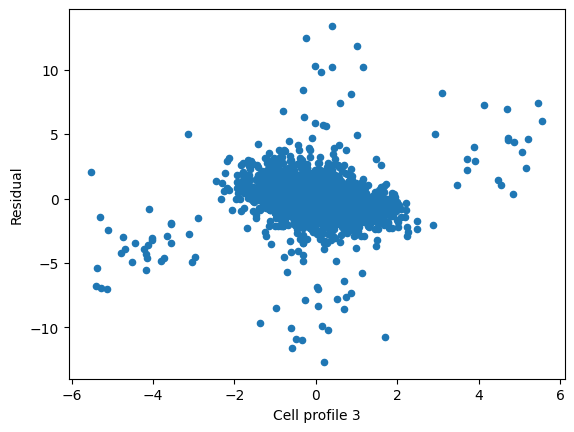

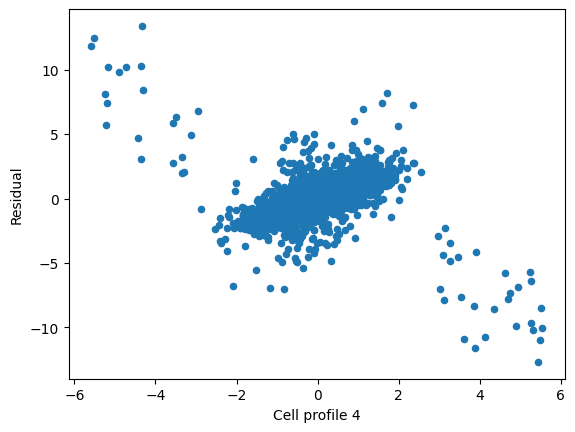

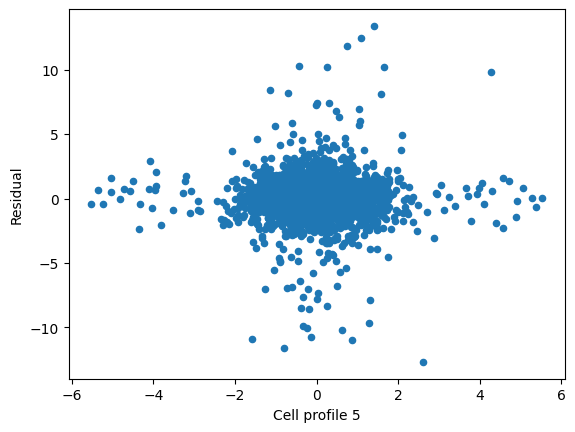

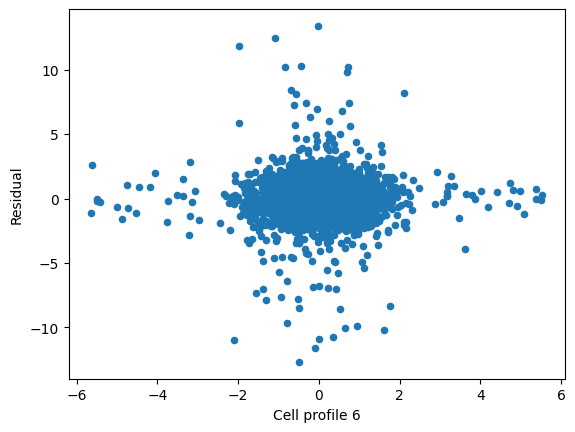

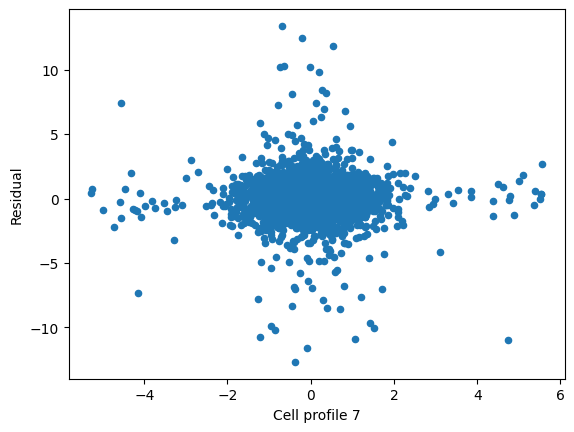

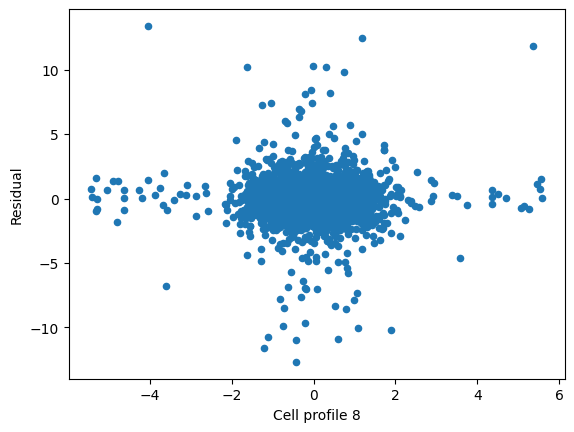

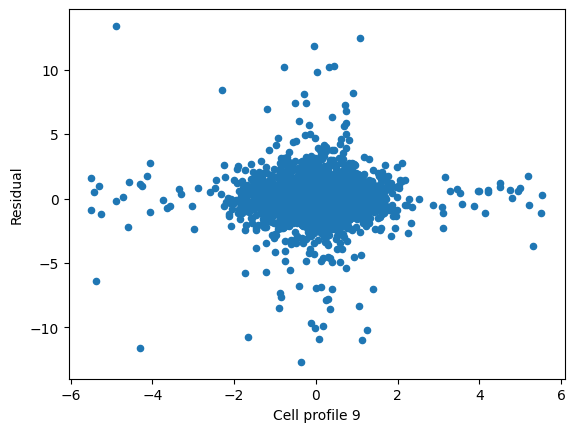

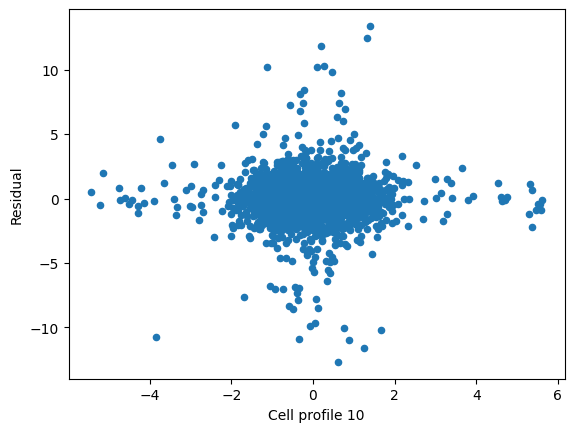

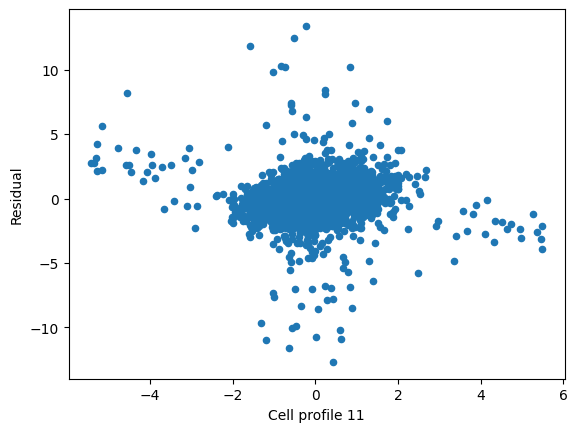

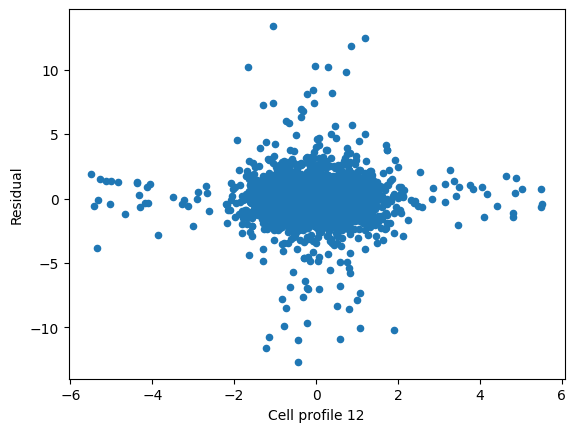

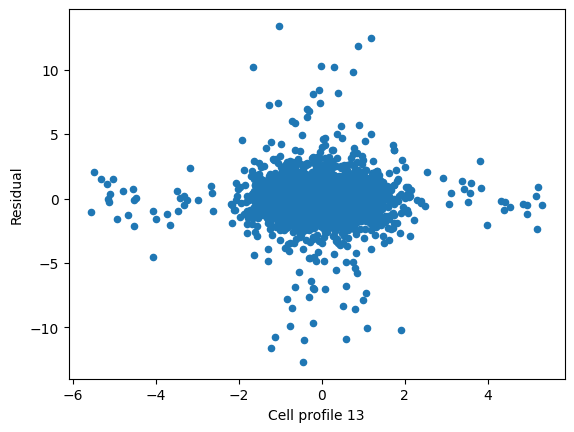

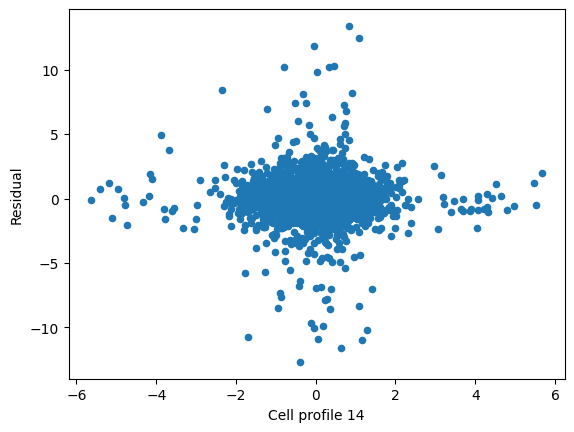

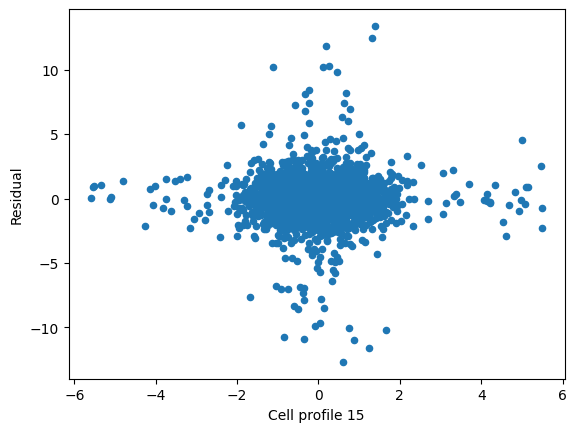

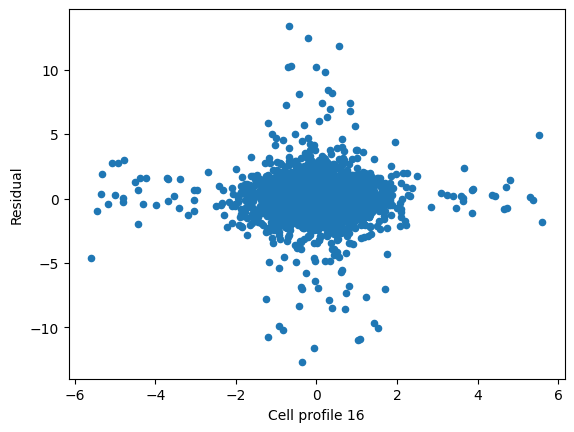

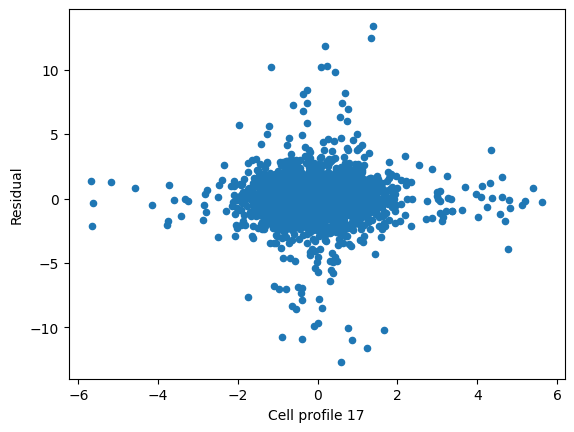

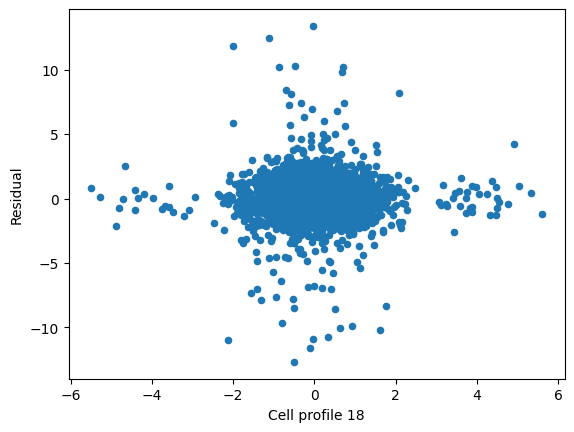

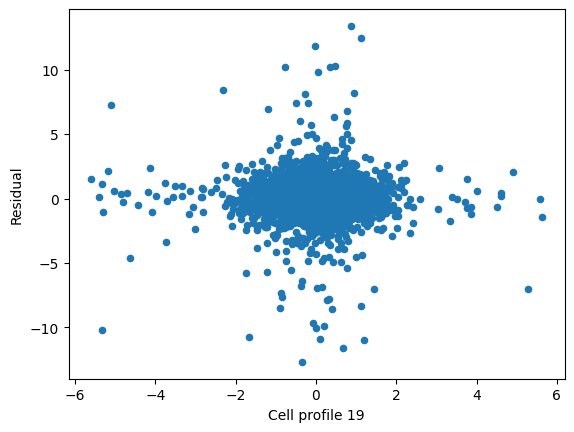

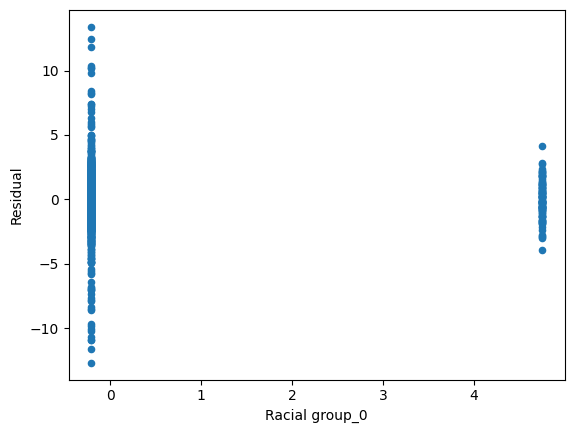

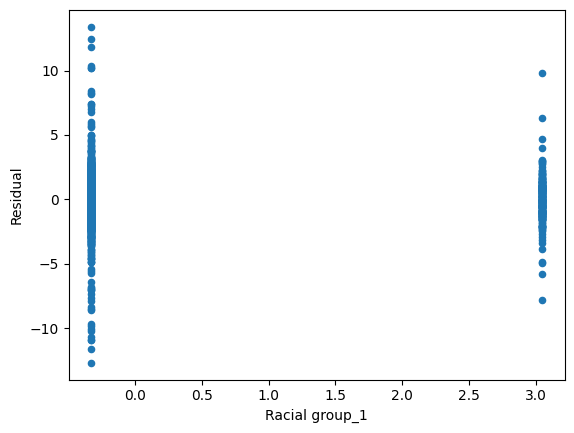

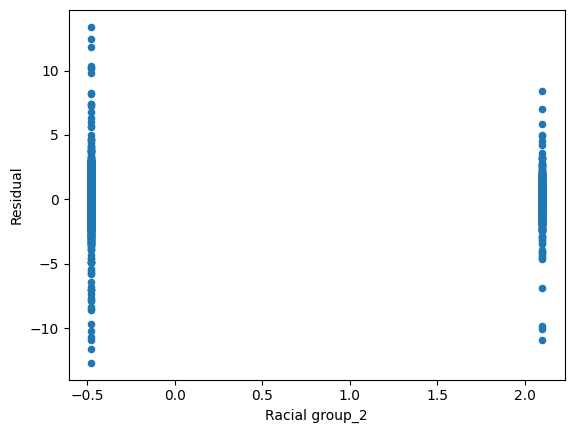

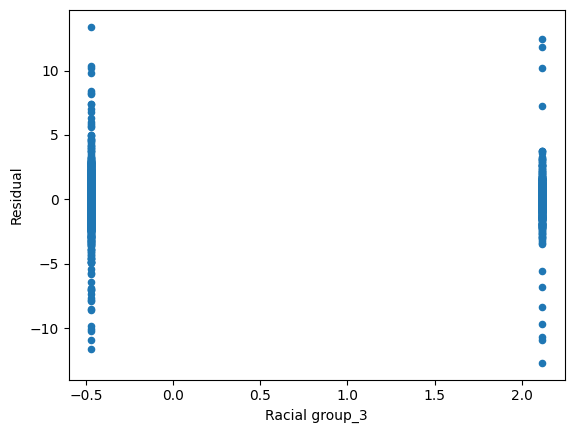

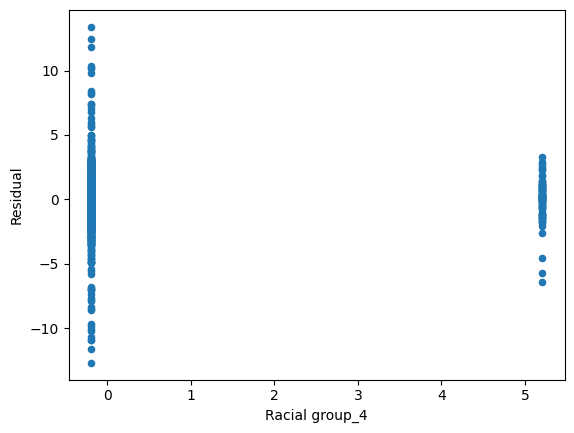

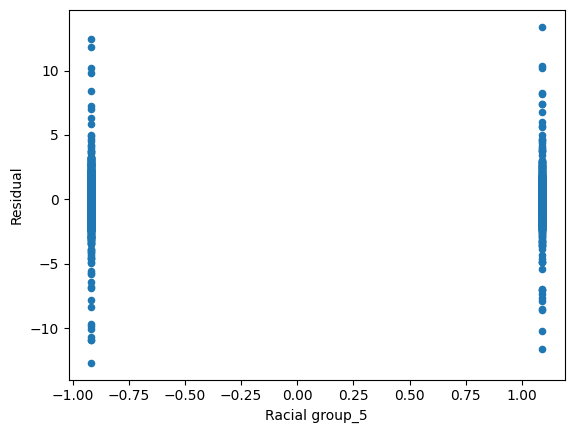

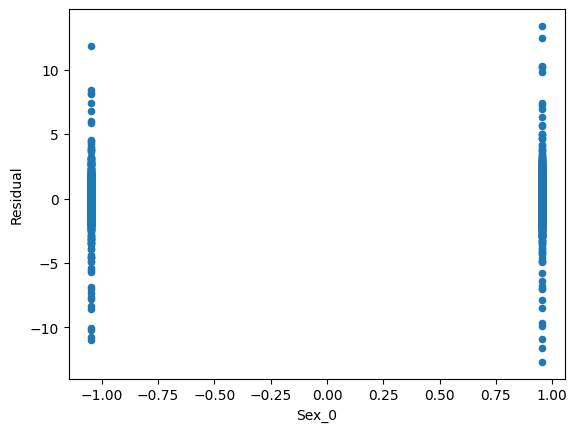

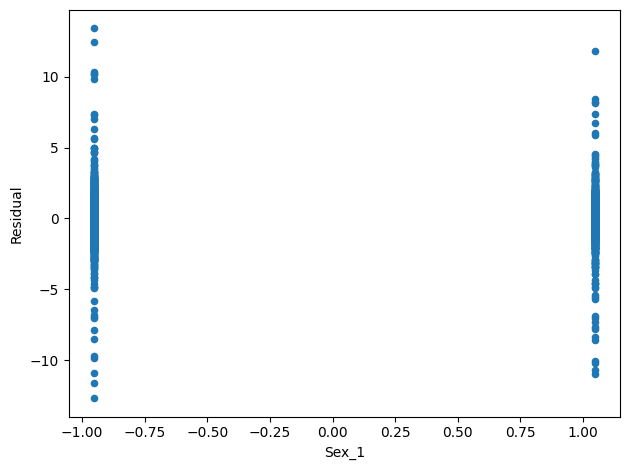

In [82]:
predictors = df_predicted.columns.copy().to_list()
predictors.remove('Prediction')
predictors.remove('Survival time (years)')
predictors.remove('Residual')
for col in predictors:
    df_predicted.plot(kind = 'scatter', x = col, y = 'Residual')
plt.tight_layout()

In [154]:
for i in list(map(lambda x : x.round(2), np.linspace(0.0, 1.0, num=6))):
    clf = sklearn.linear_model.Lasso(alpha = i)
    clf.fit(X, y)
    print(clf.score(X, y))


0.7071117012878558
0.6813260239534931
0.610649792144327
0.5079163464044096
0.39238171022755985
0.2939409565101113


/home/jake/ghub/bios_7747/.venv/lib/python3.9/site-packages/sklearn/base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/home/jake/ghub/bios_7747/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/jake/ghub/bios_7747/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.762e+03, tolerance: 2.569e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridg

In [123]:
inputData2.shape

(2500, 14)

In [142]:
inputData2 = X.copy()
inputData2 = inputData2.loc[:, ["Age (years)", "Cell profile 2", "Cell profile 3", "Cell profile 7", "Cell profile 11", "Cell profile 19", "Racial group_0", 
                   "Racial group_1", "Racial group_2", "Racial group_3", "Racial group_4", "Racial group_5", "Sex_0", "Sex_1"]
                   ]
inputData2 = inputData2.to_numpy()
def f(xData, b, *weights, alpha = 1, regularization = 'l1'):
    if regularization == 'l1':
        reg = alpha * (sum([abs(w) for w in list(weights)]))
    if regularization == 'l2':
        reg = alpha * (sum([abs(w) for w in list(weights)]))
    value = sum([weight * xData[:, i] for i,weight in enumerate(weights)] ) + b  + reg
    return value
popt, pcov = scipy.optimize.curve_fit(f, inputData2, y.ravel(), method='lm', p0=np.ones(inputData2.shape[1] + 1))
nonLinearPredictions = f(inputData2, *popt, alpha = 1)
rmse = round(np.sqrt(sklearn.metrics.mean_squared_error(y, nonLinearPredictions)), 3)
print(rmse)
print([ round(coef, 3) for coef in popt])

2.489
[1.511, 1.286, 0.566, -0.815, 0.056, 0.584, -0.014, 0.521, 0.691, 0.877, 0.847, 0.447, 0.65, -0.717, -1.315]


In [137]:
# add default bias constant
sm_data_2 = sm.add_constant(inputData2)

model = sm.OLS(y, sm_data_2)
ols2_results = model.fit()
ols2_results.params
df_ols2_summary = ols2_results.summary().tables[1]
df_ols2_summary

,coef,std err,t,P>|t|,[0.025,0.975]
const,10.8957,0.050,218.277,0.000,10.798,10.994
x1,1.2858,0.050,25.675,0.000,1.188,1.384
x2,0.5662,0.063,8.971,0.000,0.442,0.690
x3,-0.8147,0.050,-16.308,0.000,-0.913,-0.717
x4,0.0557,0.050,1.113,0.266,-0.043,0.154
x5,0.5843,0.063,9.255,0.000,0.460,0.708
x6,-0.0144,0.050,-0.287,0.774,-0.112,0.084
x7,0.1293,0.047,2.739,0.006,0.037,0.222
x8,0.1145,0.044,2.607,0.009,0.028,0.201
x9,0.1206,0.040,3.048,0.002,0.043,0.198


In [ ]:
df_predicted_2 = input.copy()
df_predicted_2.loc[:,"Survival time (years)"] = y
df_predicted_2.loc[:, "Prediction"] = nonLinearPredictions
df_predicted_2.loc[:, "Residual"] = df_predicted_2.loc[:, "Survival time (years)"] - df_predicted_2.loc[:, "Prediction"]
df_predicted_2

In [ ]:
predictors = df_predicted.columns.copy().to_list()
predictors.remove('Prediction')
predictors.remove('Survival time (years)')
predictors.remove('Residual')
for col in predictors:
    df_predicted.plot(kind = 'scatter', x = col, y = 'Residual')
plt.tight_layout()

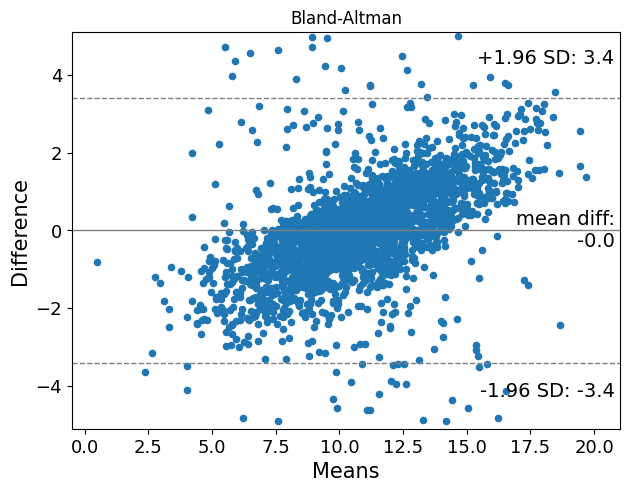

In [113]:
#create Bland-Altman plot                  
def lr_bland_altman():
    fig, ax = plt.subplots()
    sm.graphics.mean_diff_plot(df_predicted.loc[:,"Survival time (years)"], df_predicted.loc[:,"Prediction"],ax = ax)

    ax.set_title("Bland-Altman")
    plt.show()
lr_bland_altman()